In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

In [2]:
X_train, y_train, X_valid, y_valid = load_data(Gray2RGB=True, mean_proc=None, test_size=0.2)

# ResNet50 Layer Transfer

## Using Flatten

In [3]:
model_name = 'ResNet50-Layer-Transfer'

img_rows, img_cols, img_channel = 224, 224, 3

base_model = ResNet50(weights='imagenet', include_top=False, 
                      input_shape=(img_rows, img_cols, img_channel))

for layer in base_model.layers:
    #layer.trainable = False
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        #K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        #K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False
# or if we want to set the first 20 layers of the network to be non-trainable
#for layer in model.layers[:20]:
#    layer.trainable=False
#for layer in model.layers[20:]:
#    layer.trainable=True



x = base_model.output
#x = Flatten()(x)
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dense(256,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
#x = Dropout(0.5)(x)
x = Dense(256,activation='relu')(x) #dense layer 2
#x = Dropout(0.5)(x)
#x = Dense(512,activation='relu')(x) #dense layer 3
#x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [4]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-4,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

model_path = './saved_models/Transfer_CNN_0509004.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_acc', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_acc', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16
aug_ratio = 2
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)

model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/400
74/75 [============================>.] - ETA: 0s - loss: 1.3834 - acc: 0.4770
Epoch 00001: val_acc improved from -inf to 0.15894, saving model to ./saved_models/Transfer_CNN_0509004.h5
75/75 [==============================] - 31s 410ms/step - loss: 1.3771 - acc: 0.4773 - val_loss: 2.0210 - val_acc: 0.1589
Epoch 2/400
74/75 [============================>.] - ETA: 0s - loss: 0.7835 - acc: 0.7026
Epoch 00002: val_acc did not improve from 0.15894
75/75 [==============================] - 11s 144ms/step - loss: 0.7797 - acc: 0.7032 - val_loss: 2.6717 - val_acc: 0.1589
Epoch 3/400
74/75 [============================>.] - ETA: 0s - loss: 0.6077 - acc: 0.7608
Epoch 00003: val_acc did not improve from 0.15894
75/75 [==============================] - 11s 145ms/step - loss: 0.6207 - acc: 0.7590 - val_loss: 3.3532 - val_acc: 0.1589
Epoch 4/400
74/75 [============================>.] - ETA: 0s - loss: 0.4784 - acc: 0.8331
Epoch 00004: val_acc did not improve from 0.15894
75/75 [==========

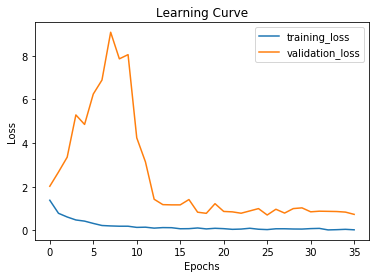

In [5]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

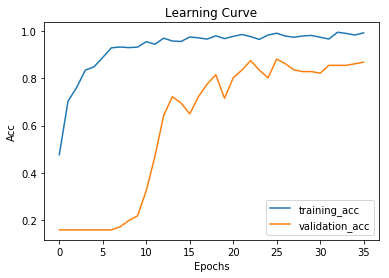

In [6]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [7]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc=None)

model = load_model(model_path)

#scores = model.evaluate(X_valid, y_valid, verbose=1)
#print('Validation loss:', scores[0])
#print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')

In [8]:
y_test_pred_df.to_csv('Transfer_CNN_0509004.csv'.format(model_name), index=False)

## Using GlobalAveragePooling2D

In [ ]:
model_name = 'ResNet50-Layer-Transfer-GlobalAveragePooling2D'

img_rows, img_cols, img_channel = 224, 224, 3

base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(img_rows, img_cols, img_channel))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.75)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16
aug_ratio = 1
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)

model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

In [ ]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [ ]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [ ]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc=None)

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

# ResNet50 Fine Tuning

In [13]:
model_name = 'ResNet50-Fine-Tuning'

img_rows, img_cols, img_channel = 224, 224, 3

base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(img_rows, img_cols, img_channel))

# for layer in base_model.layers:
#     layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dropout(0.75)(x)
# x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_98 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [14]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16
aug_ratio = 1
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)

model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/100
166/167 [============================>.] - ETA: 0s - loss: 3.4782 - acc: 0.1090
Epoch 00001: val_loss improved from inf to 3.12792, saving model to ./saved_models/ResNet50-Fine-Tuning.h5
167/167 [==============================] - 77s 459ms/step - loss: 3.4757 - acc: 0.1091 - val_loss: 3.1279 - val_acc: 0.0435
Epoch 2/100
166/167 [============================>.] - ETA: 0s - loss: 2.4992 - acc: 0.2570
Epoch 00002: val_loss improved from 3.12792 to 2.97151, saving model to ./saved_models/ResNet50-Fine-Tuning.h5
167/167 [==============================] - 29s 174ms/step - loss: 2.4983 - acc: 0.2581 - val_loss: 2.9715 - val_acc: 0.0502
Epoch 3/100
166/167 [============================>.] - ETA: 0s - loss: 1.8262 - acc: 0.4259
Epoch 00003: val_loss improved from 2.97151 to 1.96318, saving model to ./saved_models/ResNet50-Fine-Tuning.h5
167/167 [==============================] - 29s 176ms/step - loss: 1.8232 - acc: 0.4268 - val_loss: 1.9632 - val_acc: 0.3177
Epoch 4/100
166/167 [==

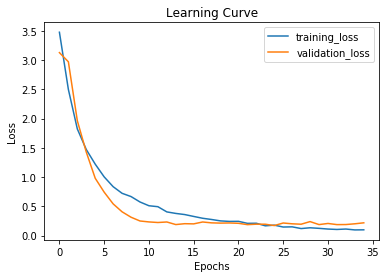

In [15]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

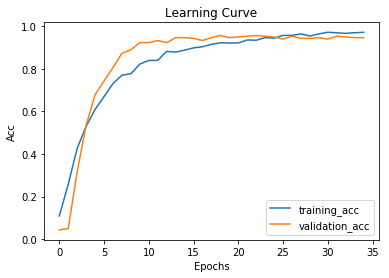

In [16]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [17]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc=None)

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 4s 12ms/step
Validation loss: 0.16998983984408172
Validation accuracy: 0.9498327759197325
